## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

The resulting perturbations can also be visualised.

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

# CIFAR_10 and Basic Model 

In [6]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 11s 0us/step


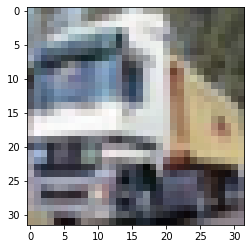

In [ ]:
plt.imshow(train_images[1])

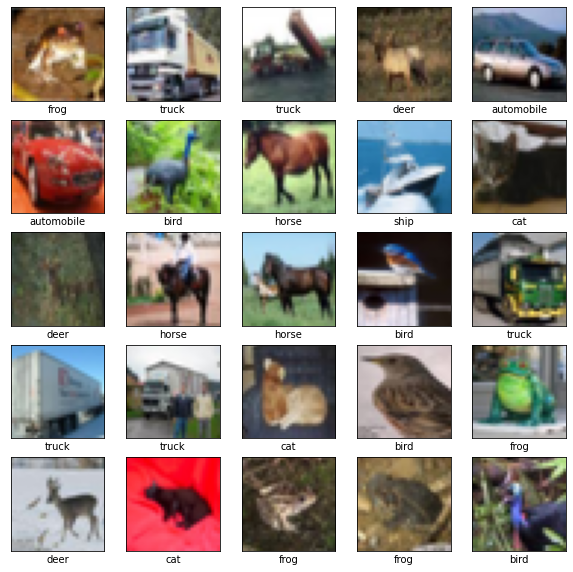

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Architecture: Conv+MaxPool+Conv+FC+FC+FC

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(65, activation="relu"))
model.add(layers.Dense(10, activation="relu"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense_3 (Dense)             (None, 65)                703105    
                                                                 
 dense_4 (Dense)             (None, 10)                660       
                                                      

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 77s 49ms/step - loss: 1.6406 - accuracy: 0.4581 - val_loss: 1.3888 - val_accuracy: 0.5552
Epoch 2/10
1563/1563 [==============================] - 76s 49ms/step - loss: 1.3215 - accuracy: 0.5750 - val_loss: 1.3131 - val_accuracy: 0.5777
Epoch 3/10
1563/1563 [==============================] - 76s 49ms/step - loss: 1.2055 - accuracy: 0.6118 - val_loss: 1.2351 - val_accuracy: 0.5994
Epoch 4/10
1563/1563 [==============================] - 77s 49ms/step - loss: 1.0437 - accuracy: 0.6589 - val_loss: 1.1225 - val_accuracy: 0.6346
Epoch 5/10
1563/1563 [==============================] - 76s 49ms/step - loss: 0.9283 - accuracy: 0.6939 - val_loss: 1.1152 - val_accuracy: 0.6374
Epoch 6/10
1563/1563 [==============================] - 76s 49ms/step - loss: 0.8550 - accuracy: 0.7177 - val_loss: 1.1233 - val_accuracy: 0.6407
Epoch 7/10
1563/1563 [==============================] - 75s 48ms/step - loss: 0.7898 - accuracy: 0.7368 - val_loss: 1.1887 -

313/313 - 4s - loss: 1.2958 - accuracy: 0.6267 - 4s/epoch - 12ms/step


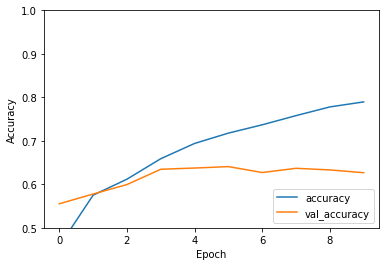

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

0.6266999840736389


# Robust Model for CFAR_10

In [98]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import optimizers

import numpy as np

In [99]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [100]:
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [101]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [7]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [8]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [9]:
#training
batch_size = 64

#opt_rms = tensorflow.keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
#opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_2 = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test))


Epoch 1/125
781/781 [==============================] - 54s 58ms/step - loss: 1.8560 - accuracy: 0.4200 - val_loss: 1.3986 - val_accuracy: 0.5589
Epoch 2/125
781/781 [==============================] - 45s 58ms/step - loss: 1.2613 - accuracy: 0.5804 - val_loss: 1.0971 - val_accuracy: 0.6597
Epoch 3/125
781/781 [==============================] - 45s 58ms/step - loss: 1.0713 - accuracy: 0.6461 - val_loss: 0.9683 - val_accuracy: 0.7033
Epoch 4/125
781/781 [==============================] - 46s 58ms/step - loss: 0.9681 - accuracy: 0.6824 - val_loss: 0.9262 - val_accuracy: 0.7121
Epoch 5/125
781/781 [==============================] - 45s 58ms/step - loss: 0.9040 - accuracy: 0.7082 - val_loss: 0.8769 - val_accuracy: 0.7337
Epoch 6/125
781/781 [==============================] - 45s 58ms/step - loss: 0.8562 - accuracy: 0.7296 - val_loss: 0.7779 - val_accuracy: 0.7653
Epoch 7/125
781/781 [==============================] - 45s 58ms/step - loss: 0.8169 - accuracy: 0.7473 - val_loss: 0.7334 - val_ac

In [46]:
#scores = model.evaluate(x_test, y_test)#, batch_size=128, verbose=1)
#test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
# Assess base model accuracy on regular images
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))
#print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0])

Base accuracy on regular images: [0.5993278622627258, 0.8600000143051147]


In [156]:
#import matplotlib.pyplot as plt
#plt.plot(model.history['accuracy'], label='accuracy')
#plt.plot(model.history['val_accuracy'], label = 'val_accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
#plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

In [102]:
#model.save('model_CFAR10.h5')
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('model_CFAR10.h5')

# Show the model architecture
model.summary()
loss, acc = new_model.evaluate(x_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

# Adversarial data generator

In [103]:
import tensorflow as tf

In [104]:
# Function to create adversarial pattern
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad 

In [105]:
# Cifar10
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#CFAR_10
img_rows, img_cols, channels = 32, 32, 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


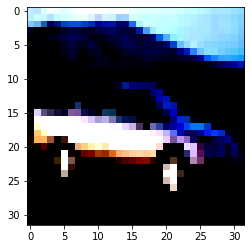

In [81]:
plt.imshow(x_train[4])

automobile
automobile
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.015 0.376 0.    0.    0.    0.    0.001 0.    0.002 0.605]]


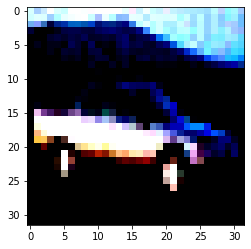

In [86]:
# Create a signle adversarial example
image = x_train[4]
image_label = y_train[4]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
perturbations
adversarial = image + perturbations * 0.08

print(labels[image_label.argmax()])
print(labels[new_model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(np.around(new_model.predict(image.reshape((1, img_rows, img_cols, channels))),decimals=3))
print(labels[new_model.predict(adversarial).argmax()])
print(np.around(new_model.predict(adversarial),decimals=3))

if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
   
plt.show()


automobile
automobile
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
frog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.    0.02  0.053 0.019 0.03  0.    0.846 0.    0.    0.031]]


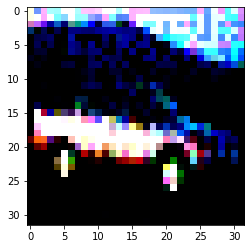

In [89]:
# Create a signle adversarial example
image = x_train[4]
image_label = y_train[4]
A=np.zeros(10)
A[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmin()]=1
label=A

#label = A[choice([i for i in range(0,9) if i not in [y_train[0].argmax()]])]=1 #Random
#label = A[0]=5 # Targeted
perturbations_2 = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)),label).numpy()
perturbations_2
adversarial_2 = image - perturbations_2 * 0.3

print(labels[image_label.argmax()])
print(labels[new_model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(np.around(new_model.predict(image.reshape((1, img_rows, img_cols, channels))),decimals=3))
print(labels[new_model.predict(adversarial_2).argmax()])
print(np.around(new_model.predict(adversarial_2),decimals=3))

if channels == 1:
    plt.imshow(adversarial_2.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial_2.reshape((img_rows, img_cols, channels)))
plt.show()

In [40]:
# Adversarial data generator
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: truck Truth: automobile


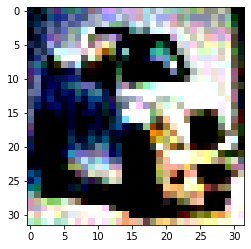

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: automobile Truth: truck


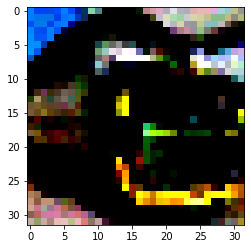

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: frog Truth: cat


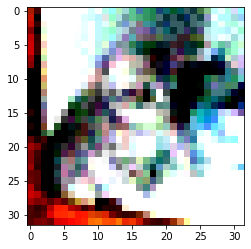

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: bird Truth: frog


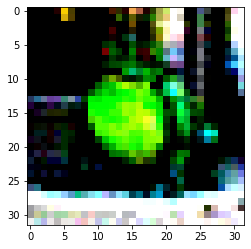

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: deer Truth: cat


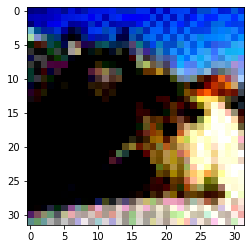

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: frog Truth: cat


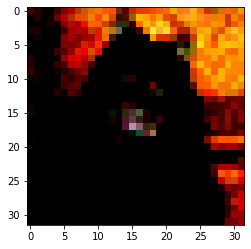

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: automobile Truth: frog


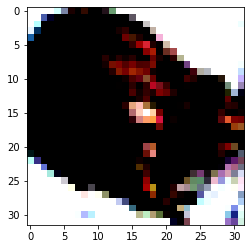

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: ship Truth: airplane


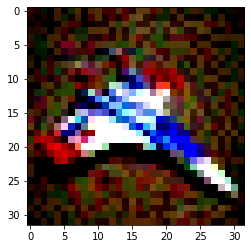

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: frog Truth: deer


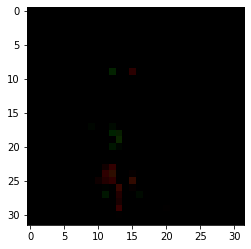

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: deer Truth: bird


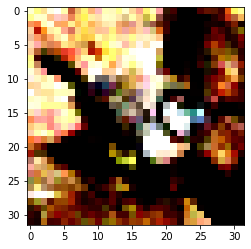

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: frog Truth: deer


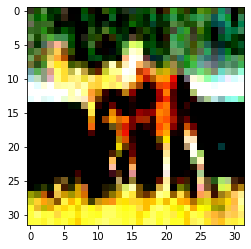

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: bird Truth: truck


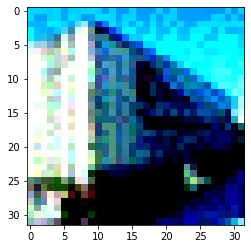

In [36]:
# Generate and visualize 12 adversarial images
import random
adversarials, correct_labels = next(generate_adversarials(12))
for adversarial, correct_label in zip(adversarials, correct_labels):
    print('Prediction:', labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()], 'Truth:', labels[correct_label.argmax()])
    if channels == 1:
        plt.imshow(adversarial.reshape(img_rows, img_cols))
    else:
        plt.imshow(adversarial)
    plt.show()

In [37]:
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))

In [41]:
# Assess base model on adversarial data
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [7.1145172119140625, 0.062199998646974564]


In [106]:
import random
# Adversarial data generator all
def generate_adversarials_all(batch_size,eps):
    epsilon=eps
    while True:
        x_FGSM = []
        x_TCM_R = []
        x_TCM_T = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0,45000)
            #epsilon = 0.1
            image = x_train[N]
            #FGSM
            label = y_train[N]
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            adversarial = image + perturbations * epsilon
            x_FGSM.append(adversarial)

            # Target Class Method (Random)
            A=np.zeros(10)
            label_A = A[random.choice([i for i in range(0,9) if i not in [y_train[N].argmax()]])]=1
            perturbations_A = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label_A).numpy()
            adversarial_A = image - perturbations_A * epsilon
            
            x_TCM_R.append(adversarial_A)

            # Target Class Method (Min_Target)
            image_label = y_train[N]
            B=np.zeros(10)
            B[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmin()]=1
            label_B=B
            perturbations_B = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label_B).numpy()
            adversarial_B = image - perturbations_B * epsilon          
            
            x_TCM_T.append(adversarial_B)

            y.append(y_train[N])
        
        
        #x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        x_FGSM = np.asarray(x_FGSM ).reshape((batch_size, img_rows, img_cols, channels))
        x_TCM_R = np.asarray(x_TCM_R).reshape((batch_size, img_rows, img_cols, channels))
        x_TCM_T = np.asarray(x_TCM_T).reshape((batch_size, img_rows, img_cols, channels))

        y = np.asarray(y)
        
        yield x_FGSM, x_TCM_R, x_TCM_T, y 

#  ACC vs Epsilon

In [95]:
x_adv_F, x_adv_R, x_adv_T, y_adv = next(generate_adversarials_all(1,0.1))

In [56]:
x_adv_F.shape
#plt.imshow(x_adv_F[].reshape(img_rows, img_cols))

(2, 32, 32, 3)

In [121]:
eps= np.arange(0.005, 0.1, 0.005)
len(eps)
C=[]
D=[]
E=[]
for i in eps:
    x_adv_F, x_adv_R, x_adv_T, y_adv = next(generate_adversarials_all(50,i))
    M1=model.evaluate(x=x_adv_F, y=y_adv, verbose=0)
    M2=model.evaluate(x=x_adv_R, y=y_adv, verbose=0)
    M3=model.evaluate(x=x_adv_T, y=y_adv, verbose=0)

    C.append([M1[1]])
    D.append(M2[1])
    E.append(M3[1])


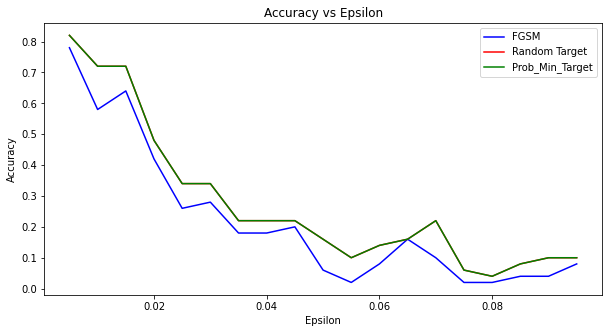

In [135]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set_title('Accuracy vs Epsilon')
x = eps
y1 = np.asarray(C)
y2 = np.asarray(D)
y3 = np.asarray(E)

plt.plot(x, y1, "-b", label="FGSM")
plt.plot(x, y2, "-r", label="Random Target")
plt.plot(x, y3, "-g", label="Prob_Min_Target")
plt.legend(loc="upper right")
ax.set_xlabel('Epsilon')
ax.set_ylabel('Accuracy')
#plt.ylim(-1.5, 2.0)
plt.show()

(150, 32, 32, 3)

# Adversarial Training (training with original data and adversarial data)

In [141]:
x_adv_F_train, x_adv_R_train, x_adv_T_train, y_adv_train = next(generate_adversarials_all(5000,0.08))
x_adv_F_test, x_adv_R_test, x_adv_T_test, y_adv_test = next(generate_adversarials_all(2000,0.08))


In [147]:
x_adversarial_train_T= np.concatenate((x_adv_F_train, x_adv_R_train, x_adv_T_train,x_train),axis=0)
y_adversarial_train_T=np.concatenate((y_adv_train, y_adv_train, y_adv_train, y_train),axis=0)
x_adversarial_test_T=np.concatenate((x_adv_F_test, x_adv_R_test, x_adv_T_test),axis=0)
y_adversarial_test_T=np.concatenate((y_adv_test, y_adv_test, y_adv_test),axis=0)


In [149]:
y_adversarial_test_T.shape
x_adversarial_test_T.shape

(6000, 32, 32, 3)

In [153]:
# Learn from adversarial data
batch_size = 64
#batch_size=batch_size,
history_adv_1 = model.fit(x_adversarial_train_T, y_adversarial_train_T, batch_size=batch_size,epochs=125,steps_per_epoch=x_adversarial_train_T.shape[0]
                    verbose=1,validation_data=(x_adversarial_test_T,y_adversarial_test_T))

Epoch 1/125
1016/1016 [==============================] - 606s 597ms/step - loss: 0.5617 - accuracy: 0.8656 - val_loss: 0.6471 - val_accuracy: 0.8382
Epoch 2/125
1016/1016 [==============================] - 599s 590ms/step - loss: 0.5200 - accuracy: 0.8833 - val_loss: 0.6264 - val_accuracy: 0.8487
Epoch 3/125
1016/1016 [==============================] - 597s 588ms/step - loss: 0.4978 - accuracy: 0.8916 - val_loss: 0.5543 - val_accuracy: 0.8673
Epoch 4/125
1016/1016 [==============================] - 578s 569ms/step - loss: 0.4850 - accuracy: 0.8966 - val_loss: 0.5213 - val_accuracy: 0.8753
Epoch 5/125
1016/1016 [==============================] - 566s 557ms/step - loss: 0.4767 - accuracy: 0.9007 - val_loss: 0.5096 - val_accuracy: 0.8883
Epoch 6/125
1016/1016 [==============================] - 587s 578ms/step - loss: 0.4673 - accuracy: 0.9042 - val_loss: 0.5595 - val_accuracy: 0.8748
Epoch 7/125
1016/1016 [==============================] - 589s 579ms/step - loss: 0.4633 - accuracy: 0.9062

KeyboardInterrupt: ignored

In [ ]:
#model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0)

#  Adversarial Training (training only with adversarial data)

In [47]:
#training
batch_size = 64

#opt_rms = tensorflow.keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
#opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_adv_1 = model.fit(x_adversarial_train, y_adversarial_train, batch_size=batch_size,epochs=125,
                    verbose=1,validation_data=(x_test,y_test))

Epoch 1/125
313/313 [==============================] - 10s 29ms/step - loss: 0.3505 - accuracy: 0.9631 - val_loss: 1.2564 - val_accuracy: 0.6669
Epoch 2/125
313/313 [==============================] - 9s 28ms/step - loss: 0.1679 - accuracy: 1.0000 - val_loss: 1.2910 - val_accuracy: 0.6664
Epoch 3/125
313/313 [==============================] - 9s 28ms/step - loss: 0.1562 - accuracy: 1.0000 - val_loss: 1.3107 - val_accuracy: 0.6646
Epoch 4/125
313/313 [==============================] - 9s 28ms/step - loss: 0.1443 - accuracy: 1.0000 - val_loss: 1.3267 - val_accuracy: 0.6609
Epoch 5/125
313/313 [==============================] - 9s 28ms/step - loss: 0.1320 - accuracy: 1.0000 - val_loss: 1.3274 - val_accuracy: 0.6592
Epoch 6/125
313/313 [==============================] - 9s 28ms/step - loss: 0.1194 - accuracy: 1.0000 - val_loss: 1.3338 - val_accuracy: 0.6550
Epoch 7/125
313/313 [==============================] - 9s 28ms/step - loss: 0.1065 - accuracy: 1.0000 - val_loss: 1.3283 - val_accuracy

KeyboardInterrupt: ignored

In [49]:
#training
batch_size = 64

#opt_rms = tensorflow.keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
#opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_adv_2 = model.fit(datagen.flow(x_adversarial_train, y_adversarial_train, batch_size=batch_size),\
                    steps_per_epoch=x_adversarial_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test))

Epoch 1/125
312/312 [==============================] - 22s 66ms/step - loss: 0.0290 - accuracy: 0.9954 - val_loss: 7.5228 - val_accuracy: 0.3099
Epoch 2/125
312/312 [==============================] - 20s 64ms/step - loss: 0.0330 - accuracy: 0.9956 - val_loss: 4.8219 - val_accuracy: 0.3866
Epoch 3/125
312/312 [==============================] - 20s 65ms/step - loss: 0.0328 - accuracy: 0.9962 - val_loss: 6.3317 - val_accuracy: 0.3552
Epoch 4/125
312/312 [==============================] - 20s 64ms/step - loss: 0.0276 - accuracy: 0.9993 - val_loss: 5.3352 - val_accuracy: 0.3552
Epoch 5/125
312/312 [==============================] - 20s 64ms/step - loss: 0.0334 - accuracy: 0.9975 - val_loss: 6.7960 - val_accuracy: 0.3137
Epoch 6/125
312/312 [==============================] - 20s 64ms/step - loss: 0.0334 - accuracy: 0.9984 - val_loss: 5.9306 - val_accuracy: 0.3417
Epoch 7/125
312/312 [==============================] - 20s 63ms/step - loss: 0.0382 - accuracy: 0.9972 - val_loss: 6.6118 - val_ac

In [50]:
# Assess defended model on adversarial data
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

# Assess defended model on regular data
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Defended accuracy on adversarial images: [0.042677443474531174, 1.0]
Defended accuracy on regular images: [10.125899314880371, 0.3041999936103821]


In [51]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Defended accuracy on adversarial images: [10.524455070495605, 0.3122999966144562]


# Review for Implement Adversarial Training FGSM  with MNIST

In [ ]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential, datasets, layers, models
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import matplotlib.pyplot as plt
import numpy as np
import random

import matplotlib.pyplot as plt

In [ ]:
#(x_train, y_train), (x_test, y_test) =  datasets.cifar10.load_data()
#MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:

# Cifar10
#labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# MNIST
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [ ]:
# Pre-process data

#CFAR_10
#img_rows, img_cols, channels = 32, 32, 3
#MNIST
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [ ]:
# Create model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

In [ ]:
# Create and fit model
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                      

In [ ]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0206 - accuracy: 0.8580 - val_loss: 0.0060 - val_accuracy: 0.9604
Epoch 2/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0091 - accuracy: 0.9407 - val_loss: 0.0043 - val_accuracy: 0.9719
Epoch 3/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0074 - accuracy: 0.9525 - val_loss: 0.0047 - val_accuracy: 0.9687
Epoch 4/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0066 - accuracy: 0.9574 - val_loss: 0.0039 - val_accuracy: 0.9742
Epoch 5/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0059 - accuracy: 0.9617 - val_loss: 0.0038 - val_accuracy: 0.9756
Epoch 6/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0053 - accuracy: 0.9665 - val_loss: 0.0037 - val_accuracy: 0.9763
Epoch 7/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0052 - accuracy: 0.9667 - val_loss: 0.0039 - val_ac

In [ ]:
# Assess base model accuracy on regular images
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.0034188255667686462, 0.9786999821662903]


In [ ]:
# Function to create adversarial pattern
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad #gradient

In [ ]:
# Create a signle adversarial example
#image = x_train[0]
#image_label = y_train[0]
#image_label.shape
#random.choice(image_label)

(10,)

In [ ]:
#image.reshape((1, img_rows, img_cols, channels)).shape
#model.predict(image.reshape((1, img_rows, img_cols, channels))).argmin()
#model.predict(image.reshape((1, img_rows, img_cols, channels)))
#y_train[0].argmax()
#x_train[10]
#from random import choice
#choice([i for i in range(0,9) if i not in [y_train[0].argmax()]])

#A=np.zeros(10)
#A[choice([i for i in range(0,9) if i not in [y_train[0].argmax()]])]=1
#A
#A.shape
#y_train[1].shape

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

zero
zero
two


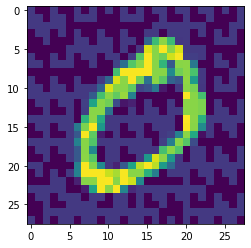

In [ ]:
# Create a signle adversarial example
image = x_train[1]
image_label = y_train[1]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
perturbations
adversarial = image + perturbations * 0.1

print(labels[image_label.argmax()])
print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial).argmax()])

if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

In [ ]:
model.predict(image.reshape((1, img_rows, img_cols, channels))).argmin()

5

zero
zero
two


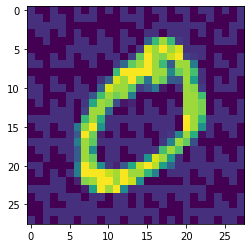

In [ ]:
# Create a signle adversarial example
image = x_train[1]
image_label = y_train[1]
A=np.zeros(10)
A[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmin()]=1
label=A
#label = A[choice([i for i in range(0,9) if i not in [y_train[0].argmax()]])]=1
#label = A[0]=5
perturbations_2 = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)),label).numpy()
perturbations_2
adversarial_2 = image - perturbations_2 * 0.08

print(labels[image_label.argmax()])
print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial_2).argmax()])

if channels == 1:
    plt.imshow(adversarial_2.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial_2.reshape((img_rows, img_cols, channels)))
plt.show()

In [ ]:
(perturbations==-perturbations_2).all()
#(adversarial==adversarial_2).all()

False

In [ ]:
# Adversarial data generator
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            image = x_train[N]
           #FGSM
            label = y_train[N]
            # Target Class Method (Random)
            A=np.zeros(10)
            label = A[choice([i for i in range(0,9) if i not in [y_train[N].argmax()]])]=1

            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
                        
            epsilon = 0.1
            #FGSM
            adversarial = image + perturbations * epsilon
            # Target Class Method
            adversarial = image - perturbations * epsilon


            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [ ]:
# Adversarial data generator
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

Prediction: three Truth: three


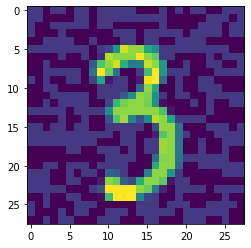

Prediction: seven Truth: three


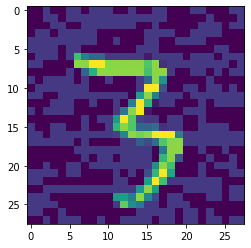

Prediction: four Truth: one


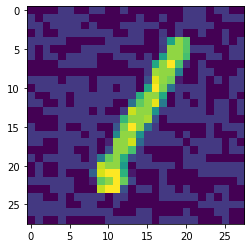

Prediction: three Truth: five


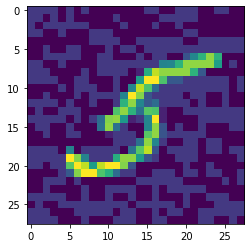

Prediction: nine Truth: zero


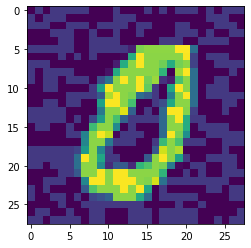

Prediction: two Truth: seven


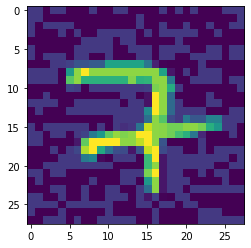

Prediction: one Truth: one


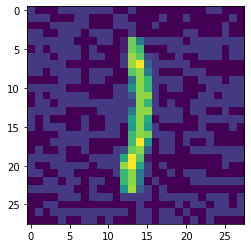

Prediction: five Truth: eight


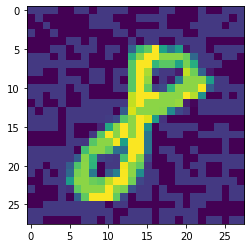

Prediction: nine Truth: four


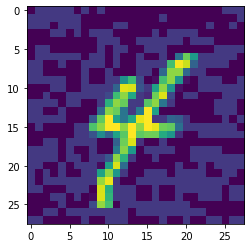

Prediction: five Truth: six


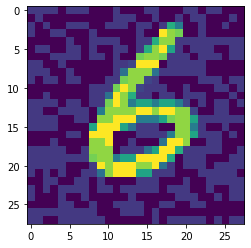

Prediction: three Truth: five


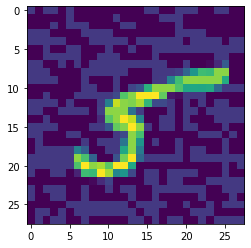

Prediction: nine Truth: seven


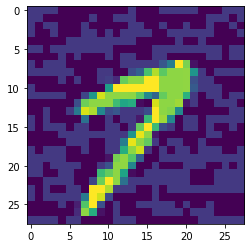

In [ ]:
# Generate and visualize 12 adversarial images
adversarials, correct_labels = next(generate_adversarials(12))
for adversarial, correct_label in zip(adversarials, correct_labels):
    print('Prediction:', labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()], 'Truth:', labels[correct_label.argmax()])
    if channels == 1:
        plt.imshow(adversarial.reshape(img_rows, img_cols))
    else:
        plt.imshow(adversarial)
    plt.show()

In [ ]:
# Generate adversarial data
# x_adversarial, y_adversarial = np.load("x_adv_10k.npy"), np.load("y_adv_10k.npy")
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))

In [ ]:
# Assess base model on adversarial data
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [0.13272175192832947, 0.24719999730587006]


In [ ]:
# Learn from adversarial data
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 1.0094e-04 - accuracy: 0.9995 - val_loss: 0.0234 - val_accuracy: 0.8777
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 3.2160e-04 - accuracy: 0.9983 - val_loss: 0.0190 - val_accuracy: 0.8990
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 1.4141e-04 - accuracy: 0.9991 - val_loss: 0.0183 - val_accuracy: 0.9032
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 1.2436e-04 - accuracy: 0.9993 - val_loss: 0.0234 - val_accuracy: 0.8772
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 5.5076e-05 - accuracy: 0.9997 - val_loss: 0.0172 - val_accuracy: 0.9096
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 2.4521e-05 - accuracy: 0.9998 - val_loss: 0.0189 - val_accuracy: 0.9003
Epoch 7/10
625/625 [==============================] - 6s 9ms/step - loss: 8.2325e-05 - accuracy: 0.9995 - val_loss: 0.0203 -

In [ ]:
# Assess defended model on adversarial data
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

# Assess defended model on regular data
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Defended accuracy on adversarial images: [0.0, 1.0]
Defended accuracy on regular images: [0.01868746429681778, 0.9032999873161316]


In [ ]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Defended accuracy on adversarial images: [0.0, 1.0]
